In [110]:
import pandas as pd
import numpy as np
from datetime import time
import math
import folium
# 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import seaborn as sns
%matplotlib inline

In [111]:
df = pd.read_excel('C:/Users/wnrrh/desktop/data/test.xlsx',header=0)

In [112]:
'''
# 파생변수 만들기

from haversine import haversine

# 시간대 관련
df['오전/오후'] = df['시간대구분'].apply(lambda x: 1 if (12<=x<=23) else 0)
df['등하교시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=9) | (13<=x<=17) else 0)
df['출퇴근시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=10) | (17<=x<=19) else 0)

# 속도 관련
df['속도준수여부'] = df['속도'].apply(lambda x:1 if x<=30 else 0)

# CCTV 관련
df.loc[df['CCTV 수'] == 0, 'CCTV설치여부'] = 0
df.loc[df['CCTV 수'] > 0, 'CCTV설치여부'] = 1

# 점심시간, 일출/일몰 , 

df['어린이 피해 여부'] = df['피해운전자 연령'].apply(lambda)'''

"\n# 파생변수 만들기\n\nfrom haversine import haversine\n\n# 시간대 관련\ndf['오전/오후'] = df['시간대구분'].apply(lambda x: 1 if (12<=x<=23) else 0)\ndf['등하교시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=9) | (13<=x<=17) else 0)\ndf['출퇴근시간'] = df['시간대구분'].apply(lambda x: 1 if (7<=x<=10) | (17<=x<=19) else 0)\n\n# 속도 관련\ndf['속도준수여부'] = df['속도'].apply(lambda x:1 if x<=30 else 0)\n\n# CCTV 관련\ndf.loc[df['CCTV 수'] == 0, 'CCTV설치여부'] = 0\ndf.loc[df['CCTV 수'] > 0, 'CCTV설치여부'] = 1\n\n# 점심시간, 일출/일몰 , \n\ndf['어린이 피해 여부'] = df['피해운전자 연령'].apply(lambda)"

In [113]:
columns = ['시설명','자치구','행정동','행정동 별 인구','면적_km','인구밀도','시간대구분','주소','도로명',
          '시설종류','구역지정수','보호구역도로폭','CCTV설치여부','CCTV 수','도로표지판 수','과속방지턱 수',
          '위도','경도','tmp','속도','총생활인구수','사망자수','중상자수','경상자수','부상신고자수','가해운전자 차종',
          '피해운전자 차종','피해운전자 연령','사고 수','통행량 도로명','통행량','오전/오후','등하교시간','출퇴근시간',
          '속도준수여부','주변보호구역유무']
df.columns = columns

In [114]:
# 위험도 산정
df['위험도'] = 0
for i in range(len(df)):
    df.loc[i,'위험도'] = (((df.loc[i,'사망자수'] + df.loc[i,'중상자수']*0.7 + df.loc[i,'경상자수']*0.3 + df.loc[i,'부상신고자수']*0.3))*0.75+(df.loc[i,'통행량'])*0.25) 

In [115]:
'''def MinMax(x):
    _max = x.max()
    _min = x.min()
    _denominator = _max - _min
    return (x- _min) / _denominator
df['위험도'] = MinMax(df['위험도'])'''

"def MinMax(x):\n    _max = x.max()\n    _min = x.min()\n    _denominator = _max - _min\n    return (x- _min) / _denominator\ndf['위험도'] = MinMax(df['위험도'])"

C:\Users\wnrrh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '위험도 분포')

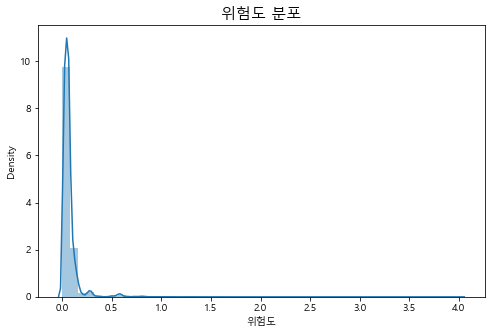

In [116]:
# 산정한 위험도 분포
plt.figure(figsize=(8,5))
sns.distplot(df['위험도'])
plt.title('위험도 분포',fontdict={'fontsize':15})

In [117]:
df['위험도'].describe()

count    36240.000000
mean         0.071240
std          0.099054
min          0.000000
25%          0.030621
50%          0.053803
75%          0.075087
max          4.017382
Name: 위험도, dtype: float64

In [118]:
## k-means clustering
from sklearn.cluster import KMeans
features = ['위험도']

X = df[features]
X_train = pd.get_dummies(X)

model = KMeans(n_clusters=3, random_state=0)
model.fit(X_train)
y_pred = model.labels_

df['cluster_label'] = y_pred

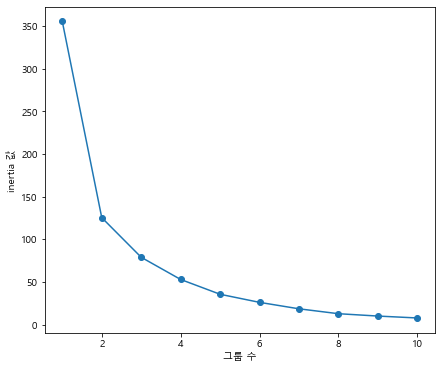

In [119]:
# 군집 수 확인 
inertia_list = []
for k in range(1,11):
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertia_list.append(model.inertia_)
plt.figure(figsize=(7,6))
plt.plot(range(1,11), inertia_list, marker='o')
plt.xlabel("그룹 수")
plt.ylabel("inertia 값")
plt.show()

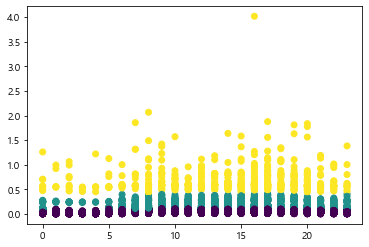

In [120]:
plt.scatter(x = df["시간대구분"], y = df["위험도"], c=y_pred)

In [121]:
print(df['총생활인구수'].corr(df['위험도']))
print(df['인구밀도'].corr(df['위험도']))
print(df['인구밀도'].corr(df['사고 수']))

-0.010423934158219655
-0.0030142643614555972
0.013531974515567615


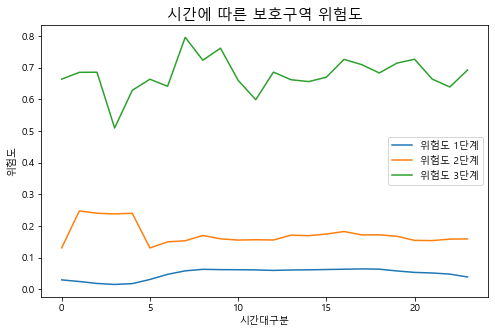

In [122]:
# 클러스터링 결과 시각화
plt.figure(figsize = (8,5))
sns.lineplot(data=df[df['cluster_label']==0],x='시간대구분', y='위험도', ci=None, label='위험도 1단계')
sns.lineplot(data=df[df['cluster_label']==1],x='시간대구분', y='위험도', ci=None, label='위험도 2단계')
sns.lineplot(data=df[df['cluster_label']==2],x='시간대구분', y='위험도', ci=None, label='위험도 3단계')
# sns.lineplot(data=df[df['cluster_label']==3],x='시간대구분', y='위험도', ci=None, label='위험도 4단계')
plt.title('시간에 따른 보호구역 위험도',fontdict = {'fontsize':15})
plt.legend()
plt.show()

In [123]:
df['위험도 군집'] = df['cluster_label'].apply(lambda x :1 if x==0 else (2 if x==1 else 3 ))

In [124]:
# dtype 변환
df.dtypes

df['구역지정수'] = df['구역지정수'].astype('float')
df['CCTV설치여부'] = df['CCTV설치여부'].astype('float')
df['과속방지턱 수'] = df['과속방지턱 수'].astype('float')
df['사고 수'] = df['사고 수'].astype('float')
df['오전/오후'] = df['오전/오후'].astype('float')
df['등하교시간'] = df['등하교시간'].astype('float')
df['출퇴근시간'] = df['출퇴근시간'].astype('float')
df['속도준수여부'] = df['속도준수여부'].astype('float')
df['CCTV 수'] = df['CCTV 수'].astype('float')
df['시간대구분'] = df['시간대구분'].astype('float')
df['행정동 별 인구'] = df['행정동 별 인구'].astype('float')
df['인구밀도'] = df['인구밀도'].astype('float')

In [125]:
df = df.astype({'위험도 군집' : 'float'})

In [126]:
df

,시설명,자치구,행정동,행정동 별 인구,면적_km,인구밀도,시간대구분,주소,도로명,시설종류,...,통행량 도로명,통행량,오전/오후,등하교시간,출퇴근시간,속도준수여부,주변보호구역유무,위험도,cluster_label,위험도 군집
0,덕수유치원,성북구,성북동,17404.0,2.86,6085.0,3.0,서울특별시 성북구 성북로 127 (성북동),성북로,유치원(일반),...,대사관로(삼청터널),0.000000,0.0,0.0,0.0,0.0,1,0.000000,0,1.0
1,서울다원학교,성북구,성북동,17404.0,2.86,6085.0,3.0,서울특별시 성북구 성북로31길 5-15 (성북동),성북로31길,특수학교,...,대사관로(삼청터널),0.000000,0.0,0.0,0.0,0.0,1,0.000000,0,1.0
2,덕수유치원,성북구,성북동,17404.0,2.86,6085.0,2.0,서울특별시 성북구 성북로 127 (성북동),성북로,유치원(일반),...,대사관로(삼청터널),0.000284,0.0,0.0,0.0,0.0,1,0.000071,0,1.0
3,서울다원학교,성북구,성북동,17404.0,2.86,6085.0,2.0,서울특별시 성북구 성북로31길 5-15 (성북동),성북로31길,특수학교,...,대사관로(삼청터널),0.000284,0.0,0.0,0.0,0.0,1,0.000071,0,1.0
4,서울후암초등학교,용산구,후암동,18202.0,0.86,21165.0,3.0,서울특별시 용산구 두텁바위로 140,두텁바위로,초등학교,...,소파로(숭의여자대학교),0.000860,0.0,0.0,0.0,0.0,1,0.000215,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36235,서울우신초등학교,영등포구,신길4동,12974.0,0.38,34142.0,14.0,서울특별시 영등포구 신길로 190 (신길동),신길로,초등학교,...,경인로(서울교),0.375869,1.0,1.0,0.0,1.0,1,0.543967,2,3.0
36236,선희유치원,도봉구,쌍문4동,19297.0,0.52,37110.0,20.0,서울특별시 도봉구 해등로 241 (쌍문동),해등로,유치원(일반),...,도봉로(쌍문역),0.139611,1.0,0.0,0.0,1.0,1,1.834903,2,3.0
36237,서울강서초등학교,양천구,신월4동,18487.0,0.52,35552.0,19.0,서울특별시 양천구 오목로 31 (신월동),오목로,초등학교,...,남부순환로(신월IC),0.339756,1.0,0.0,1.0,1.0,1,1.809939,2,3.0
36238,신길에덴유치원,영등포구,신길4동,12974.0,0.38,34142.0,15.0,서울특별시 영등포구 신길로38길 21 (신길동),신길로38길,유치원(일반),...,경인로(서울교),0.371547,1.0,1.0,0.0,1.0,1,0.767887,2,3.0


In [127]:
# 입력 변수 생성
features = df.columns
X = df[features].drop(['시설명','주소','사망자수','부상신고자수','중상자수','도로명','행정동','자치구','위도','경도','총생활인구수',
'cluster_label','경상자수','위험도 군집','위험도','tmp','위험도 군집','통행량','통행량 도로명'],axis=1)
Y = df['위험도 군집']

In [128]:
# 랜덤포레스트 라이브러리
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestRegressor

In [129]:
# 연속형 변수 
numeric_features = X.select_dtypes("float").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 처리
categorical_features = X.select_dtypes("object").columns.to_list()
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#컬럼 변환
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        # ('cat', categorical_transformer, categorical_features)])


In [130]:
# Training / Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
Y_train = Y_train.astype('int')   

테스트 정확도: 0.9720


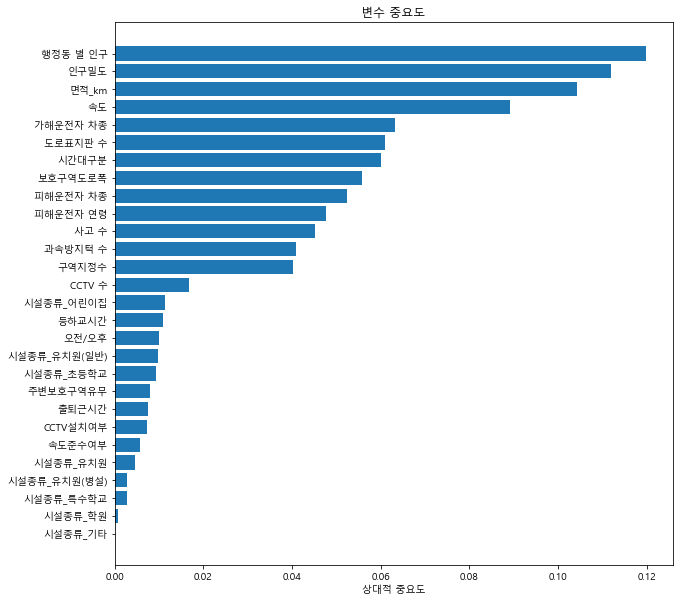

In [131]:
# 랜덤 포레스트 변수 중요도

# random forest pipeline
pipe = make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
pipe.fit(X_train,Y_train)
y_pred = pipe.predict(X_test)
print('테스트 정확도: %.4f'% pipe.score(X_test,Y_test))

# 변수 중요도
rf = RandomForestClassifier(random_state=0)
rf.fit(pd.get_dummies(X_train),Y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('변수 중요도')
plt.barh(range(len(indices)), importances[indices],color = 'tab:blue', align ='center')
plt.yticks(range(len(indices)), [pd.get_dummies(X_train).columns[i] for i in indices])
plt.xlabel('상대적 중요도')
plt.show()



In [82]:
df['피해운전자 연령'].describe()

count    36240.000000
mean         1.186119
std          7.528026
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         91.000000
Name: 피해운전자 연령, dtype: float64

SVM

In [86]:
from sklearn.svm import SVC
pipe_svm = make_pipeline(preprocessor,SVC())

# Parameter list
param_grid = [{'svc_C': [1,5,10,50,100],
            'svc_gamma':[0.001,0.01,0.1,1],
            'svc_kernel':['rbf']}]

scores = {'accuracy':make_score(accuracy_score),
         'precision': make_score(precision_score, average = 'macro'),
         'recall':make_score(recall_score, average = 'macro'),
         'f1_macro': make_score(f1_score, average ='macro'),
          'f1_weighted':makre_score(f1_score, average='weighted')}
# GridSearch
gs_svm = GridSearchCV(estimator = pipe_svm,
                     param_grid = param_grid,
                      scoring = scorers,
                      refit = 'f1_weighted',
                      cv = 5 
                        n_jobs=-1)

gs_svm.fit(X_train,Y_train)
print('최적 매개변수 조합 :%s' %gs_svm.best_params_)
print('CV 정확도 : %4f'%gs_svm.best_score_)

clf_svm = gs_svm.best_estimator_
print('테스트 정확도: %3f'%clf_svm.score(X_test,Y_test))

SyntaxError: invalid syntax (<ipython-input-86-6054cde069ab>, line 20)

In [ ]:
# LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb 
params = {'learning rate':0.05,
          'max_depth': 10,
          'num_iterations':1000,
          'boosting_type':'gbdt',
          'sub_feature':0.5,
          'num_leaves' : 10,
          'min_data':50,
          'min_child_samples':20,
          'subsample':0.8
         }
# 그리드서칭 시행할 하이퍼파라미터
gridParams = {'max_depth':[3,5,7],
            'learning rate':[0.01, 0.05, 0.1, 0.2]
            'num_iteration':[1000]
            'min_child_weight':[5,10,20]
             }

# 측도 다양하게 사용
scores = {'accuracy': make_score(accuracy_score),
         'precision': make_score(precision_score, average='macro')
         
         }

In [83]:
print(classification_report(Y_test,lgb_model_GS.predict(X_test)))

NameError: name 'lgb_model_GS' is not defined